In [11]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [26]:
data = pd.read_csv("C:/Users/luizf/Desktop/MINDS/Datasets/energydata_complete.csv")
data.pop('date')
data.pop('rv1')
data.pop('rv2')
#data.pop('T9')
#data.pop('T6')
#data.pop('Windspeed')
X=data.copy()
X.drop(data.tail(1).index,inplace=True)
X
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60.0,30.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
1,50.0,30.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
2,50.0,40.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
3,60.0,40.0,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
4,50.0,40.0,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,45.730000,...,18.1000,48.590000,17.000000,45.2900,6.016667,734.0,92.000000,5.333333,43.833333,4.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19729,100.0,0.0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19730,90.0,0.0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19731,270.0,10.0,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19732,420.0,10.0,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=32)

y_train, y_test = train_test_split(y, test_size=0.25, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
y_train = scaler.fit_transform(y_train.values)
y_val = scaler.fit_transform(y_val.values)

In [28]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [29]:
def train_gru(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
        #y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
        #y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = GRUModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [30]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [31]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_gru(X_train, layer_dim=1, dropout_prob=0, epochs=300, batch_size=64, learning_rate=0.001, step_wdecay=50, gamma_wdecay=0.5)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\AppData\Local\Temp/ipykernel_24848/1568283450.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (rmse/x)
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.n

In [32]:
result

,window,rmse,mape,mae,r2,variable,smape,nrmse
0,0,87.241797,66.330502,60.969916,0.446359,Appliances,25.484369,0.181754
1,0,5.252217,inf,4.277469,0.452767,lights,72.936874,0.175074
2,0,0.397627,1.413303,0.310796,0.712591,T1,0.705436,0.159051
3,0,1.374328,2.162292,0.842664,0.459223,RH_1,1.073719,0.099878
4,0,0.585876,1.892021,0.395363,0.427243,T2,0.932927,0.174888
...,...,...,...,...,...,...,...,...
775,19082,0.280265,0.027629,0.208825,0.171017,Press_mm_hg,0.013814,0.200189
776,19082,4.624348,6.041934,3.938401,0.901047,RH_out,3.062259,0.102763
777,19082,0.652723,26.397102,0.514874,0.391931,Windspeed,11.769128,0.217574
778,19082,10.087178,24.019722,8.270889,0.563731,Visibility,10.213050,0.229254


In [34]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_24848/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_24848/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


,variable,rmse,mae,mape,r2,smape,nrmse,rmse_std,mae_std,mape_std,r2_std,smape_std,nrmse_std
0,Appliances,77.568311,49.342682,55.394094,2.333484e-01,21.872297,0.139083,39.052666,28.267784,26.524653,1.399165e-01,7.882699,0.036081
1,lights,5.674960,3.983542,inf,2.043731e-01,84.863103,inf,2.413421,1.997555,NaN,2.595988e-01,12.753859,NaN
2,T1,0.272318,0.214198,1.000289,7.641743e-01,0.499812,0.138707,0.134377,0.102907,0.522822,1.640150e-01,0.259076,0.045383
3,RH_1,1.018430,0.733969,1.823083,5.641146e-01,0.914281,0.120904,0.423539,0.364579,1.017224,2.471471e-01,0.505569,0.029207
4,T2,0.496521,0.393779,1.909739,7.520908e-01,0.953827,0.141861,0.198069,0.167032,0.747789,1.433406e-01,0.373084,0.042555
5,RH_2,0.944473,0.750555,1.893455,7.080079e-01,0.945014,0.129874,0.426902,0.366761,0.964420,1.884611e-01,0.480846,0.039883
6,T3,0.348148,0.267680,1.182745,4.088544e-01,0.590083,0.180067,0.240814,0.180245,0.727905,3.267521e-01,0.361827,0.059361
7,RH_3,0.668518,0.520406,1.327782,5.560855e-01,0.664722,0.148263,0.277768,0.210964,0.544704,2.083607e-01,0.272680,0.038915
8,T4,0.430076,0.342920,1.690081,4.641447e-01,0.844175,0.184972,0.318275,0.250165,1.284621,3.003956e-01,0.638061,0.046605
9,RH_4,0.699083,0.562992,1.438127,5.910041e-01,0.718737,0.146691,0.275224,0.238639,0.610317,2.595878e-01,0.303511,0.036368


In [35]:
pd.DataFrame(final_measures).to_csv('gru_appliances_result.csv')

In [23]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.06911269190394034


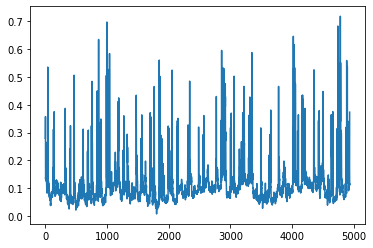

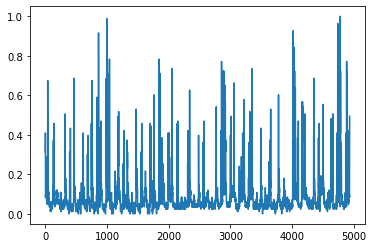

In [20]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [24]:
print (model)

GRUModel(
  (gru): GRU(22, 20, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
